<a href="https://colab.research.google.com/github/BeastHunter0041/csci_4170_s26/blob/main/%2001_datasheet_and_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Information Sheet

**Name:** Great Lakes Fish Biodiversity & Habitat (subset)

**Motivation:**  
This dataset captures fish species observations and habitat characteristics across the Great Lakes region. A predictive model could support ecological risk assessment and biodiversity monitoring by identifying conditions associated with species presence.

**Target definition:**  
Binary indicator of whether a given fish species is present in an observation record.

**Source:**  
Canadian Government/Great Lakes Fish Biodiversity Science dataset.

**Link/License:**

https://catalogue.arctic-sdi.org/geonetwork/srv/api/records/02bf1fca-2fda-11e9-a466-1860247f53e3

Open Government License - Canada.

**Instances:**  
2,100 observations (subset from a larger ecological dataset of 100000 observations).

**Example features:**
- Water body identifier (categorical)
- Habitat type (categorical)
- Depth (numeric)
- Substrate composition (categorical)
- Sampling method (categorical)
- Environmental measurements (numeric)
- Species metadata (categorical)

**Known limitations / risks:**
- The data is purley observational, no randomization present
- There is a strong likelhood of sampling bias for easy to access locations (map of observations)
- Due to a large collection region, species absence may reflect non-detection rather than true absence.

In [18]:
import pandas as pd

df = pd.read_csv("/content/GL_FishBiodiversity_first_2100.csv")

print("Shape:", df.shape)
#print(df.head)

# Missingness summary (top 15 columns by fraction missing)
missing = df.isna().mean().sort_values(ascending=False)
print("\nTop missingness columns:")
print(missing.head(15))

# Duplicate rows check
print("\nExact duplicate rows:", df.duplicated().sum())

# Target distribution (binary presence/absence from Number Captured)
TARGET = "Number Captured"
y = (df[TARGET] > 0).astype(int)

print("\nTarget distribution (1 = captured/present, 0 = none/absent):")
print(y.value_counts())


Shape: (2100, 93)

Top missingness columns:
Date fished              1.0
Arrival Time             1.0
Departure Time           1.0
Salinity                 1.0
Wind Speed (km/h)        1.0
Dominant Vegetation      1.0
Bank Slope (degrees)     1.0
None                     1.0
Bin_time_s               1.0
Water velocity (msec)    1.0
Not recorded             1.0
Unknown_aqua_veg         1.0
Unknown                  1.0
Bedrock                  1.0
Hardpan                  1.0
dtype: float64

Exact duplicate rows: 0

Target distribution (1 = captured/present, 0 = none/absent):
Number Captured
1    2082
0      18
Name: count, dtype: int64


## Leakage-risk note

**High Cardinality fields**:
- consists of Project Name, Field Number
- these could act as ids, thus training memorization of specific samples
- Mitigation: drop this information, in order to prevent incorrect training of the model

**Date/Time fields**:
- consists of date fished, year/month/day, start/stop time
- these may encode seasonal patterns, such as certain species of fish being more abundant in certain seasons, which is not the primary focus of this analysis.
-Mitigation: drop these fields

**Size fields**:
- contains minimum(mm), maximum (mm)
-these measurements are directly dependent on a captured fish
- if this was included in the model, we try to infer presence from normally unavailable information
- Remove post-outcome measurement fields from the feature set.

In [11]:
# Target: number of species captured
y = (df["Number Captured"] > 0).astype(int)

# Drop columns that are obvious leakage / identifiers / post-outcome / hard memorization
DROP_COLS = [
    "Project Name", "Field Number", "Narrative Locality Description",
    "Species",                       # if kept, the model can trivially learn species-specific detectability
    "Number Captured",               # target source
    "Caught > Number captured",      # post-outcome / derived
    "Minimum (mm)", "Maximum (mm)"   # post-catch measurements (post-outcome)
]

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")

# Quick check: ensure we still have plenty of columns
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())


X shape: (2100, 85)
y distribution:
 Number Captured
1    2082
0      18
Name: count, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1680, 85) Test: (420, 85)


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(exclude="number").columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=7))
])

model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Date fished' 'Arrival Time' 'Departure Time' 'pH' 'Secchi Tube (m)'
 'Turbidity (ntu)' 'Sample Area Width (m)' 'Sample Area Length (m)'
 'Dominant Vegetation' 'Bank Slope (degrees)' 'Wind Speed (km/h)'
 'TDS (g/L)' 'Salinity' 'Bedrock' 'Hardpan' 'Concrete' 'Unknown_substrate'
 'Substrate_not_determined' 'Not_recorded_aqua_veg' 'Unknown_aqua_veg'
 'None' 'Unknown' 'Not recorded' 'Water velocity (msec)' 'Bin_time_s']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Day', 'Month', 'Year', 'Date fished', 'Arrival Time', 'Departure Time',
       'Start Latitude', 'Start Longitude', 'Stop Latitude', 'Stop Longitude',
       'Effort', 'Amps (A)', 'Volts (V)', 'Power (%)', 'Pulse/sec (Hz)...
                                                  Index(['Date', 'Waterbody Name', 'WaterbodyType', 'Start Time', 'Stop Time',
       'Gear', 'Description of Gear', 'Quantification of Effort',
       'Sampling_Method', 'Secchi Disc > measured', 'Secchi Tube > measured',
       'Habitat Type', 'Floodplain Use', 'Wind Direction', 'Province',
       'Dominant_substrate', 'Dominant_aqua_veg', 'Dominant_riparian_veg',
       'depth_>_recorded'],
      dtype='object'))])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Date fished' 'Arrival Time' 'Departure Time' 'pH' 'Secchi Tube (m)'
 'Turbidity (ntu)' 'Sample Area Width (m)' 'Sample Area Length (m)'
 'Dominant Vegetation' 'Bank Slope (degrees)' 'Wind Speed (km/h)'
 'TDS (g/L)' 'Salinity' 'Bedrock' 'Hardpan' 'Concrete' 'Unknown_substrate'
 'Substrate_not_determined' 'Not_recorded_aqua_veg' 'Unknown_aqua_veg'
 'None' 'Unknown' 'Not recorded' 'Water velocity (msec)' 'Bin_time_s']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Test F1: 0.9952153110047847


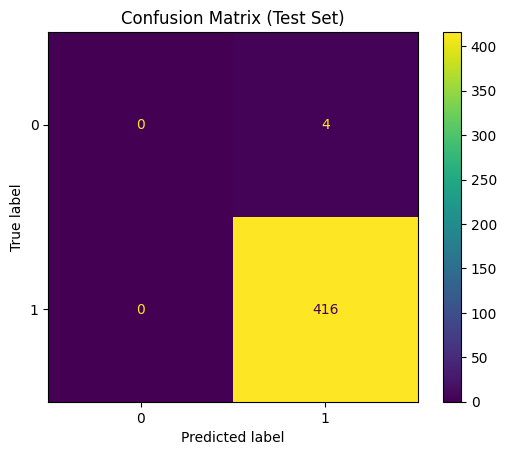

In [14]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("Test F1:", f1)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()


## Brief reflection

- The dataset required careful target construction: presence was defined as `Number Captured > 0`.
- The main leakage risks are identifiers (Project/Field), free-text locality, and post-catch measurements.
- A single Pipeline was used to prevent preprocessing leakage.
- Next steps: test a second baseline (GaussianNB), refine feature exclusions (especially geospatial), and consider a grouped or location-aware split if near-duplicates are present.

_____________________________
# Model Card

## Intended use
Predict whether a species is detected at a sampling event to prioritize follow-up monitoring. Not for regulatory or high-stakes decisions.

## Data
Great Lakes fish biodiversity sampling data (2,100-row subset). Target constructed as `Number Captured > 0`.

## Model
kNN classifier inside a single scikit-learn Pipeline:
- Numeric: median imputation + standard scaling
- Categorical: most-frequent imputation + one-hot encoding

## Metrics
Primary: F1 on a stratified 80/20 split  
Supporting: confusion matrix

## Limitations
- Observational data + sampling bias
- “Absence” can be non-detection
- Potential geographic memorization if coordinates/location proxies remain

## Risks
- Under-sampled habitats may be misclassified
- Performance may be inflated if near-duplicate sampling events exist

## Mitigations
- Dropped ID-like columns and post-outcome fields
- Split before preprocessing; Pipeline prevents leakage
